In [6]:
!pip install opacus transformers datasets accelerate peft torch rouge-score bert-score nltk pandas scikit-learn

In [7]:
!pip install peft==0.6.0
!pip install --upgrade peft
!pip install bitsandbytes
!pip install shap

  Using cached peft-0.6.0-py3-none-any.whl.metadata (23 kB)
Using cached peft-0.6.0-py3-none-any.whl (134 kB)
  Attempting uninstall: peft
    Found existing installation: peft 0.15.1
    Uninstalling peft-0.15.1:
      Successfully uninstalled peft-0.15.1
  Using cached peft-0.15.1-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.15.1-py3-none-any.whl (411 kB)
  Attempting uninstall: peft
    Found existing installation: peft 0.6.0
    Uninstalling peft-0.6.0:
      Successfully uninstalled peft-0.6.0


In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\my pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from datasets import load_dataset

# Load medical abstract dataset
train_data = load_dataset('csv', data_files='medical_tc_train.csv', split='train')
test_data = load_dataset('csv', data_files='medical_tc_test.csv', split='train')

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import pipeline
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
from torch import nn, optim
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler
from opacus import PrivacyEngine
from torch.utils.data import DataLoader


In [11]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and LoRA configuration
model_name = "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, config=config)

# Prepare for LoRA adaptation
#model = prepare_model_for_kbit_training(model)
#lora_config = LoraConfig(
#    task_type="CAUSAL_LM",
#    r=8,
#    lora_alpha=32,
#    lora_dropout=0.1,
#    target_modules=["c_attn", "c_proj"]
#)
#model = get_peft_model(model, lora_config)
# Move to device
model.to(device)
# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples['medical_abstract'], truncation=True, padding='max_length', max_length=128
    )
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)
train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask"])

# DataLoader
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)


In [6]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and LoRA configuration
model_name = "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, config=config)

# Prepare for LoRA adaptation
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj"]
)
model = get_peft_model(model, lora_config)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples['medical_abstract'], truncation=True, padding='max_length', max_length=128
    )
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)
train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask"])

# DataLoader
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Privacy Engine
privacy_engine = PrivacyEngine()
sample_rate = 16 / len(train_data)  # Batch size / dataset size
model, optimizer, train_dataloader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    target_epsilon=10.0,
    target_delta=1e-5,
    epochs=3,
    max_grad_norm=1.0
)

# Move to device
model.to(device)
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()

    return total_loss / len(dataloader)

# Training loop
epochs = 3
for epoch in range(epochs):
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        model.train()
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Loss: {loss.item():.4f}")   
    # Validation
    val_loss = evaluate(model, test_dataloader, device)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss / len(train_dataloader):.4f}, Validation Loss: {val_loss:.4f}")
    delta = 1e-5  # Failure probability
    epsilon = privacy_engine.get_epsilon(delta)
    print(f"Epoch [{epoch+1}/{epochs}], ε: {epsilon:.2f}")
    torch.cuda.empty_cache()

C:\Users\my pc\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\peft\tuners\lora\layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
C:\Users\my pc\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\opacus\privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\my pc\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\my pc\.ai-navigator\micromamba\envs\cuda\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains 

Epoch [1/3], Step [0], Loss: 3.0331
Epoch [1/3], Step [10], Loss: 2.9529
Epoch [1/3], Step [20], Loss: 3.0956
Epoch [1/3], Step [30], Loss: 2.8082
Epoch [1/3], Step [40], Loss: 3.1995
Epoch [1/3], Step [50], Loss: 2.8669
Epoch [1/3], Step [60], Loss: 3.0378
Epoch [1/3], Step [70], Loss: 3.2540
Epoch [1/3], Step [80], Loss: 2.9763
Epoch [1/3], Step [90], Loss: 2.8798
Epoch [1/3], Step [100], Loss: 3.4034
Epoch [1/3], Step [110], Loss: 3.2424
Epoch [1/3], Step [120], Loss: 3.0689
Epoch [1/3], Step [130], Loss: 2.9084
Epoch [1/3], Step [140], Loss: 2.9959
Epoch [1/3], Step [150], Loss: 2.7924
Epoch [1/3], Step [160], Loss: 2.9244
Epoch [1/3], Step [170], Loss: 2.8712
Epoch [1/3], Step [180], Loss: 2.8881
Epoch [1/3], Step [190], Loss: 2.8136
Epoch [1/3], Step [200], Loss: 3.1427
Epoch [1/3], Step [210], Loss: 3.0548
Epoch [1/3], Step [220], Loss: 3.2744
Epoch [1/3], Step [230], Loss: 2.6948
Epoch [1/3], Step [240], Loss: 2.7298
Epoch [1/3], Step [250], Loss: 3.0394
Epoch [1/3], Step [260]

In [16]:
#original_model = model._module
#original_model.save_pretrained("./lora_dp_medical_gpt2")
#tokenizer.save_pretrained("./lora_dp_medical_gpt2")
#print("LoRA-adapted model and tokenizer saved successfully!")
# Save the model after every epoch (or at desired intervals)
def save_model(model, epoch, filename='lora_dp_medical_gpt2_1.pth'):
    state_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict()
    }
    torch.save(state_dict, filename)
    print(f"Model saved to {filename}")  
model = model._module
save_model(model, epoch)

Model saved to lora_dp_medical_gpt2.pth


In [12]:
def load_model(model,filename='lora_dp_medical_gpt2.pth'):
    # Load the state_dict from the saved file
    checkpoint = torch.load(filename)
    epoch = checkpoint['epoch']
    model.resize_token_embeddings(len(tokenizer))
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print(f"Model loaded from {filename}")
    return model, epoch

In [13]:
# Load LoRA-adapted model
#from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load the LoRA fine-tuned model and tokenizer
#tokenizer = AutoTokenizer.from_pretrained("./lora_dp_medical_gpt2")
#model = AutoModelForCausalLM.from_pretrained("./lora_dp_medical_gpt2").to("cuda" if torch.cuda.is_available() else "cpu")

# Create the text-generation pipeline
#generator_model = pipeline(
#    "text-generation",
#    model=model,
#    tokenizer=tokenizer,
#    device=0 if torch.cuda.is_available() else -1  # Use GPU if available, otherwise CPU
#)
generator_model, start_epoch = load_model(model)

print("Generator model loaded successfully!")



C:\Users\my pc\AppData\Local\Temp\ipykernel_8016\471032133.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Model loaded from lora_dp_medical_gpt2.pth
Generator model loaded successfully!


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sample 0: Perplexity = 3.1743
Sample 1: Perplexity = 2.2180
Sample 2: Perplexity = 3.1415
Sample 3: Perplexity = 5.4810
Sample 4: Perplexity = 6.2156
Sample 5: Perplexity = 4.5078
Sample 6: Perplexity = 2.2030
Sample 7: Perplexity = 3.1079
Sample 8: Perplexity = 2.5134
Sample 9: Perplexity = 3.0154
Sample 10: Perplexity = 2.1163
Sample 11: Perplexity = 1.8245
Sample 12: Perplexity = 2.5606
Sample 13: Perplexity = 2.0853
Sample 14: Perplexity = 2.4567
Sample 15: Perplexity = 5.5928
Sample 16: Perplexity = 2.0354
Sample 17: Perplexity = 2.1670
Sample 18: Perplexity = 2.3279
Sample 19: Perplexity = 2.3305
Sample 20: Perplexity = 2.0377
Sample 21: Perplexity = 4.6762
Sample 22: Perplexity = 5.2142
Sample 23: Perplexity = 1.9608
Sample 24: Perplexity = 2.4346
Sample 25: Perplexity = 2.6405
Sample 26: Perplexity = 4.9070
Sample 27: Perplexity = 2.9576
Sample 28: Perplexity = 1.7604
Sample 29: Perplexity = 2.4136
Sample 30: Perplexity = 1.9526
Sample 31: Perplexity = 3.1462
Sample 32: Perplex

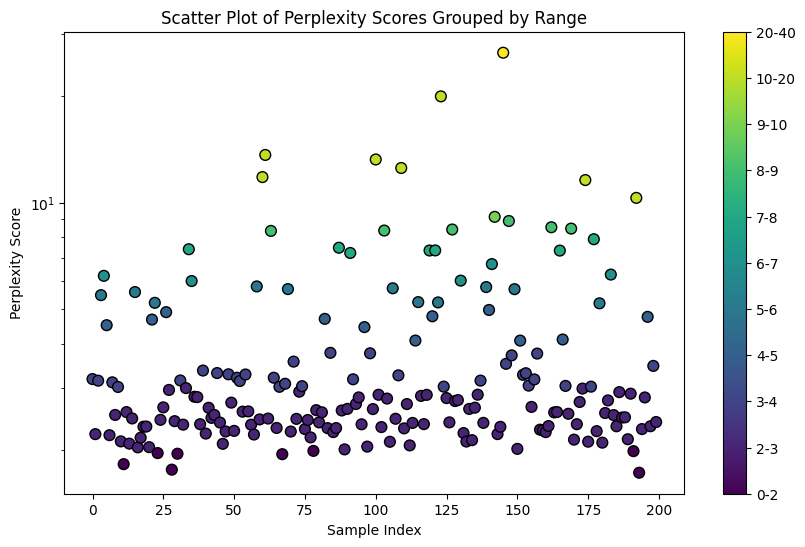

In [9]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the dataset
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:200].tolist()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create prompts from the first 50 words
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Loop over prompts, generate text, and record perplexity scores
perplexity_scores = []
for i, prompt in enumerate(prompts):
    generated_text_str = generate_long_text(generator_model, tokenizer, prompt, max_length=300)
    perplexity = calculate_perplexity(generator_model, tokenizer, generated_text_str)
    perplexity_scores.append(perplexity)
    print(f"Sample {i}: Perplexity = {perplexity:.4f}")

# Save perplexity scores to a CSV file
df = pd.DataFrame({
    "Index": range(len(perplexity_scores)),
    "Perplexity": perplexity_scores
})
df.to_csv("lora_dp_med_gpt_perplexity_scores.csv", index=False)
print("Perplexity scores saved to perplexity_scores.csv")

# Group perplexity scores into defined ranges.
# For this example, we group scores as: 0-20, 20-40, 40-60, 60-80, 80-100, and 100+
bins = [0,2,3,4,5,6,7,8,9,10,20, 40, 60, 80, 100, float('inf')]
labels = ["0-2", "2-3","3-4","4-5","5-6","6-7","7-8","8-9","9-10","10-20","20-40", "40-60", "60-80", "80-100", "100+"]
df["Perplexity Group"] = pd.cut(df["Perplexity"], bins=bins, labels=labels)

# Create a scatter plot of perplexity scores.
plt.figure(figsize=(10, 6))
# Color-code by perplexity group using categorical codes.
scatter = plt.scatter(df["Index"], df["Perplexity"], 
                      c=df["Perplexity Group"].cat.codes, cmap="viridis", s=60, edgecolor="k")
plt.xlabel("Sample Index")
plt.ylabel("Perplexity Score")
plt.title("Scatter Plot of Perplexity Scores Grouped by Range")
plt.yscale("log")  # Use logarithmic scale to better visualize a wide range of values.
# Create a colorbar with group labels.
cbar = plt.colorbar(scatter, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)
plt.savefig("lora_dp_med_gpt_perplexity_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [1]:
!pip install panda

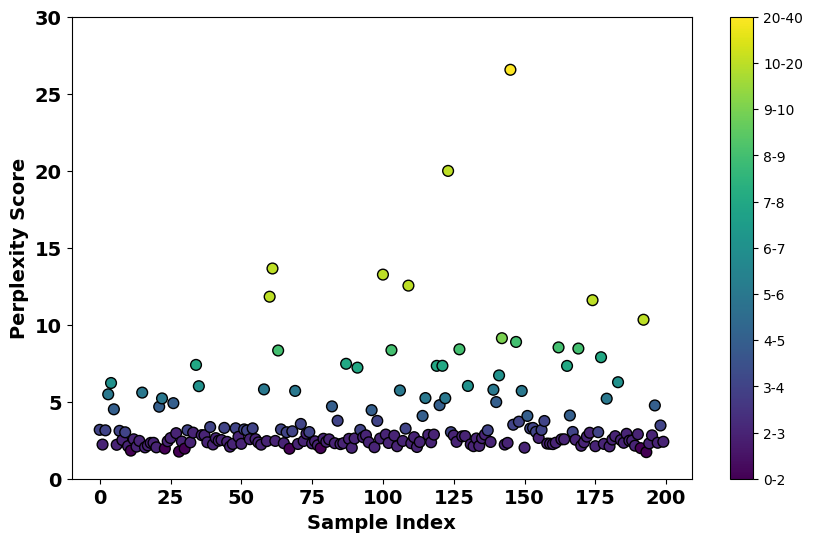

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("lora_dp_med_gpt_perplexity_scores.csv")
# Group perplexity scores into defined ranges.
# For this example, we group scores as: 0-20, 20-40, 40-60, 60-80, 80-100, and 100+
bins = [0,2,3,4,5,6,7,8,9,10,20, 40, 60, 80, 100, float('inf')]
labels = ["0-2", "2-3","3-4","4-5","5-6","6-7","7-8","8-9","9-10","10-20","20-40", "40-60", "60-80", "80-100", "100+"]
df["Perplexity Group"] = pd.cut(df["Perplexity"], bins=bins, labels=labels)

# Create a scatter plot of perplexity scores.
plt.figure(figsize=(10, 6))
# Color-code by perplexity group using categorical codes.
scatter = plt.scatter(df["Index"], df["Perplexity"], 
                      c=df["Perplexity Group"].cat.codes, cmap="viridis", s=60, edgecolor="k")
plt.xlabel("Sample Index", fontweight="bold", fontsize=14)
plt.ylabel("Perplexity Score", fontweight="bold", fontsize=14)
plt.xticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold
plt.yticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold

plt.title("", fontweight="bold", fontsize=16)

# Fix y-axis range from 0 to 100
plt.ylim(0, 30)

# Create a colorbar with group labels.
cbar = plt.colorbar(scatter, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)

plt.savefig("lora_dp_med_gpt_perplexity_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
import numpy as np
np.mean(perplexity_scores)

3.822636927366257

In [10]:
!pip install rouge

In [11]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load the dataset
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:10].tolist()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create prompts from the first 50 words
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

def evaluate_generated_texts(reference_text, generated_text):
    reference_list = reference_text.split()
    generated_list = generated_text.split()

    # BLEU Score
    bleu_score = sentence_bleu([reference_list], generated_list)

    # ROUGE Scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_text, reference_text)[0]
    P = rouge_scores['rouge-l']['p']
    R = rouge_scores['rouge-l']['r']
    F1 = rouge_scores['rouge-l']['f']

    # Cosine Similarity
    vectorizer = CountVectorizer().fit_transform([reference_text, generated_text])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)[0][1]

    return bleu_score, rouge_scores, P, R, F1, cos_sim

# Evaluation Loop
total_bleu, total_rougeL, total_perplexity, total_sim = 0, 0, 0, 0
for i, prompt in enumerate(prompts):
    reference_text = texts[i]
    generated_text_str = generate_long_text(model, tokenizer, prompt, max_length=500)

    print(f"Reference Text: {reference_text}")
    print(f"Generated Text: {generated_text_str}")

    bleu_score, rouge_scores, P, R, F1, cos_sim = evaluate_generated_texts(reference_text, generated_text_str)
    perplexity = calculate_perplexity(model, tokenizer, generated_text_str)

    print(f"BLEU: {bleu_score}, ROUGE-L: {rouge_scores['rouge-l']}, Perplexity: {perplexity}, Cosine Similarity: {cos_sim:.4f}")
    
    # Accumulate scores
    total_bleu += bleu_score
    total_rougeL += rouge_scores['rouge-l']['f']
    total_perplexity += perplexity
    total_sim += cos_sim

# Averages
num_samples = len(prompts)
print("Average BLEU:", total_bleu / num_samples)
print("Average ROUGE-L:", total_rougeL / num_samples)
print("Average Perplexity:", total_perplexity / num_samples)
print("Average Cosine Similarity:", total_sim / num_samples)



The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Reference Text: Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration was 6.2 h on both study nights), and sleep stage distribution was similar on both nights. Obstructive apneas and hypopn

In [ ]:
torch.cuda.empty_cache()

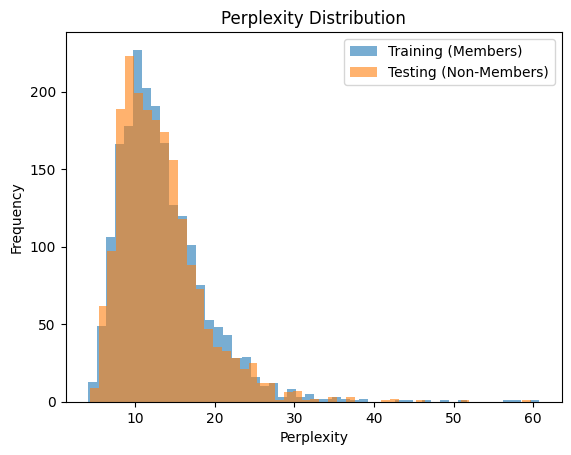

              precision    recall  f1-score   support

           0       0.49      0.80      0.61       378
           1       0.59      0.26      0.36       422

    accuracy                           0.52       800
   macro avg       0.54      0.53      0.49       800
weighted avg       0.55      0.52      0.48       800



In [9]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load your datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

# Extract texts
train_texts = train_df["medical_abstract"][:2000].tolist()  # Adjust column name if needed
test_texts = test_df["medical_abstract"][:2000].tolist()    # Adjust column name if needed

# Function to calculate perplexity for a single text
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate perplexities for a list of texts
def calculate_perplexities(model, tokenizer, texts, device):
    perplexities = []
    for text in texts:
        try:
            perplexity = calculate_perplexity(model, tokenizer, text, device)
            perplexities.append(perplexity)
        except Exception as e:
            print(f"Error calculating perplexity for text: {text}\n{e}")
            perplexities.append(float("inf"))  # Assign high perplexity for invalid cases
    return perplexities

# Calculate perplexities for training and test datasets
train_perplexities = calculate_perplexities(generator_model, tokenizer, train_texts, device)
test_perplexities = calculate_perplexities(generator_model, tokenizer, test_texts, device)

# Combine perplexities and prepare labels
labels = [1] * len(train_perplexities) + [0] * len(test_perplexities)
perplexities = train_perplexities + test_perplexities

# Visualize perplexity distributions
plt.hist(train_perplexities, bins=50, alpha=0.6, label="Training (Members)")
plt.hist(test_perplexities, bins=50, alpha=0.6, label="Testing (Non-Members)")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Perplexity Distribution")
plt.show()

# Prepare data for membership inference model
import numpy as np
X = np.array(perplexities).reshape(-1, 1)
y = np.array(labels)

# Split into training and testing sets for the inference model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


Optimal Threshold: -7.368638038635254
TPR: 0.08 and FPR: 0.07


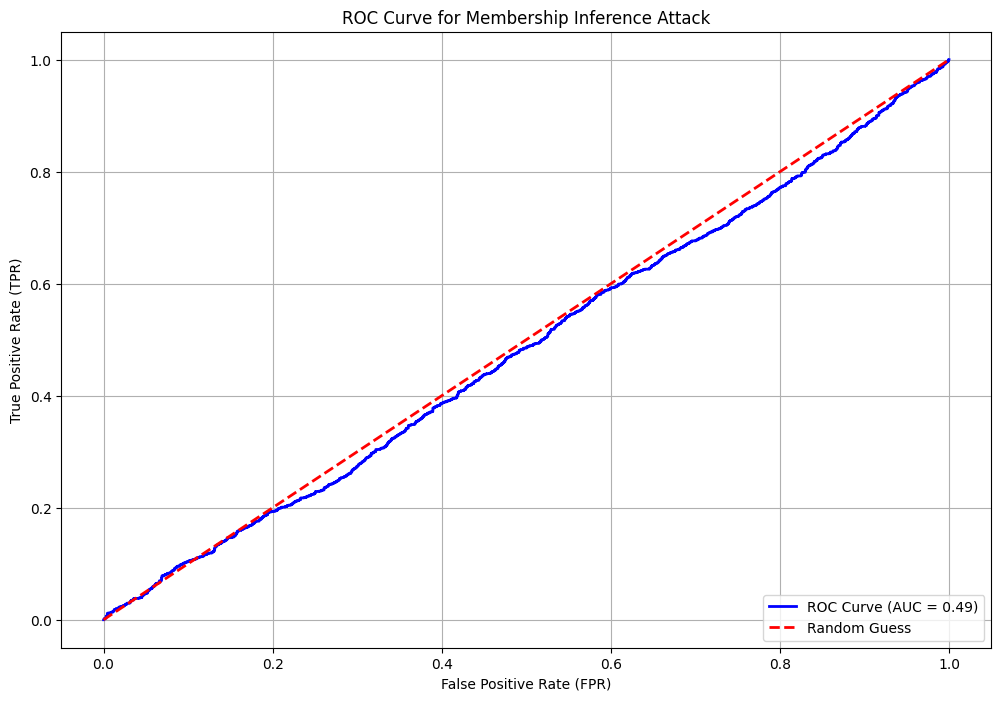

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, -np.array(perplexities))  # Use negative perplexity for descending order

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# Get TPR and FPR at the optimal threshold
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

# Print the results
print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR: {optimal_tpr:.2f} and FPR: {optimal_fpr:.2f}")

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Membership Inference Attack")
plt.legend(loc="lower right")
plt.grid()
plt.show()


[LightGBM] [Info] Number of positive: 156, number of negative: 164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

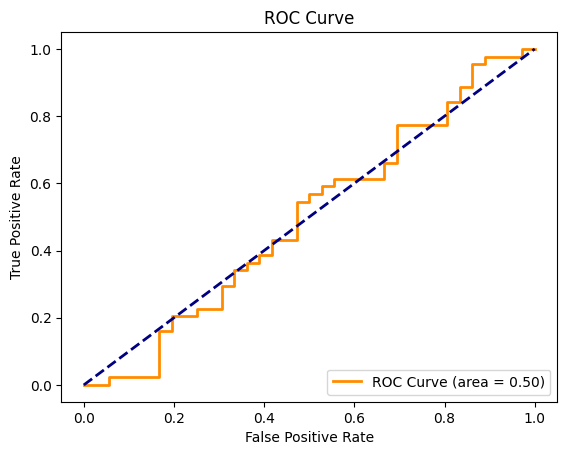

In [9]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:200].tolist()
test_texts = test_df["medical_abstract"][:200].tolist()

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        embeddings = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            embedding = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
test_features = calculate_features(generator_model, tokenizer, test_texts, train_centroid, device)

# Combine features and labels
train_labels = [1] * len(train_texts)  # Members
test_labels = [0] * len(test_texts)    # Non-members

combined_features = np.vstack((
    np.column_stack(train_features),
    np.column_stack(test_features)
))
combined_labels = np.array(train_labels + test_labels)

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(combined_features)

# Split data for training the attack model
X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42)

# Train LightGBM attack model
clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the attack model
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
#plt.savefig("lora_dp_roc_plots.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [14]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:200].tolist()
test_texts = test_df["medical_abstract"][:200].tolist()

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        embeddings = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            embedding = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)
test_centroid = calculate_centroid(generator_model, tokenizer, test_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        prompt = ' '.join(str(text).split()[:50])
        #print(prompt)
        text = generate_long_text(model, tokenizer, prompt, max_length=300)
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

# Open CSV file to store results
csv_filename = "lora_dp_med_txt_gen_attack_model_results.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Run", "Precision", "Recall", "F1-Score", "ROC-AUC"])

    for run in range(1, 11):  # Run 10 times
        print(f"Run {run}...")
        train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
        test_features = calculate_features(generator_model, tokenizer, test_texts, test_centroid, device)
    
        # Combine features and labels
        train_labels = [1] * len(train_texts)  # Members
        test_labels = [0] * len(test_texts)    # Non-members
    
        combined_features = np.vstack((
            np.column_stack(train_features),
            np.column_stack(test_features)
        ))
        combined_labels = np.array(train_labels + test_labels)
        # Normalize features
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(combined_features)      
        
        # Split data for training the attack model
        X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42 + run)

        # Train LightGBM attack model
        clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
        clf.fit(X_train, y_train)

        # Evaluate the attack model
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report["macro avg"]["precision"]
        recall = report["macro avg"]["recall"]
        f1_score = report["macro avg"]["f1-score"]
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, ROC-AUC: {roc_auc:.4f}")

        # Save to CSV
        writer.writerow([run, precision, recall, f1_score, roc_auc])

print(f"Results saved to {csv_filename}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Run 1...
[LightGBM] [Info] Number of positive: 165, number of negative: 155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [10]:
!pip install seaborn

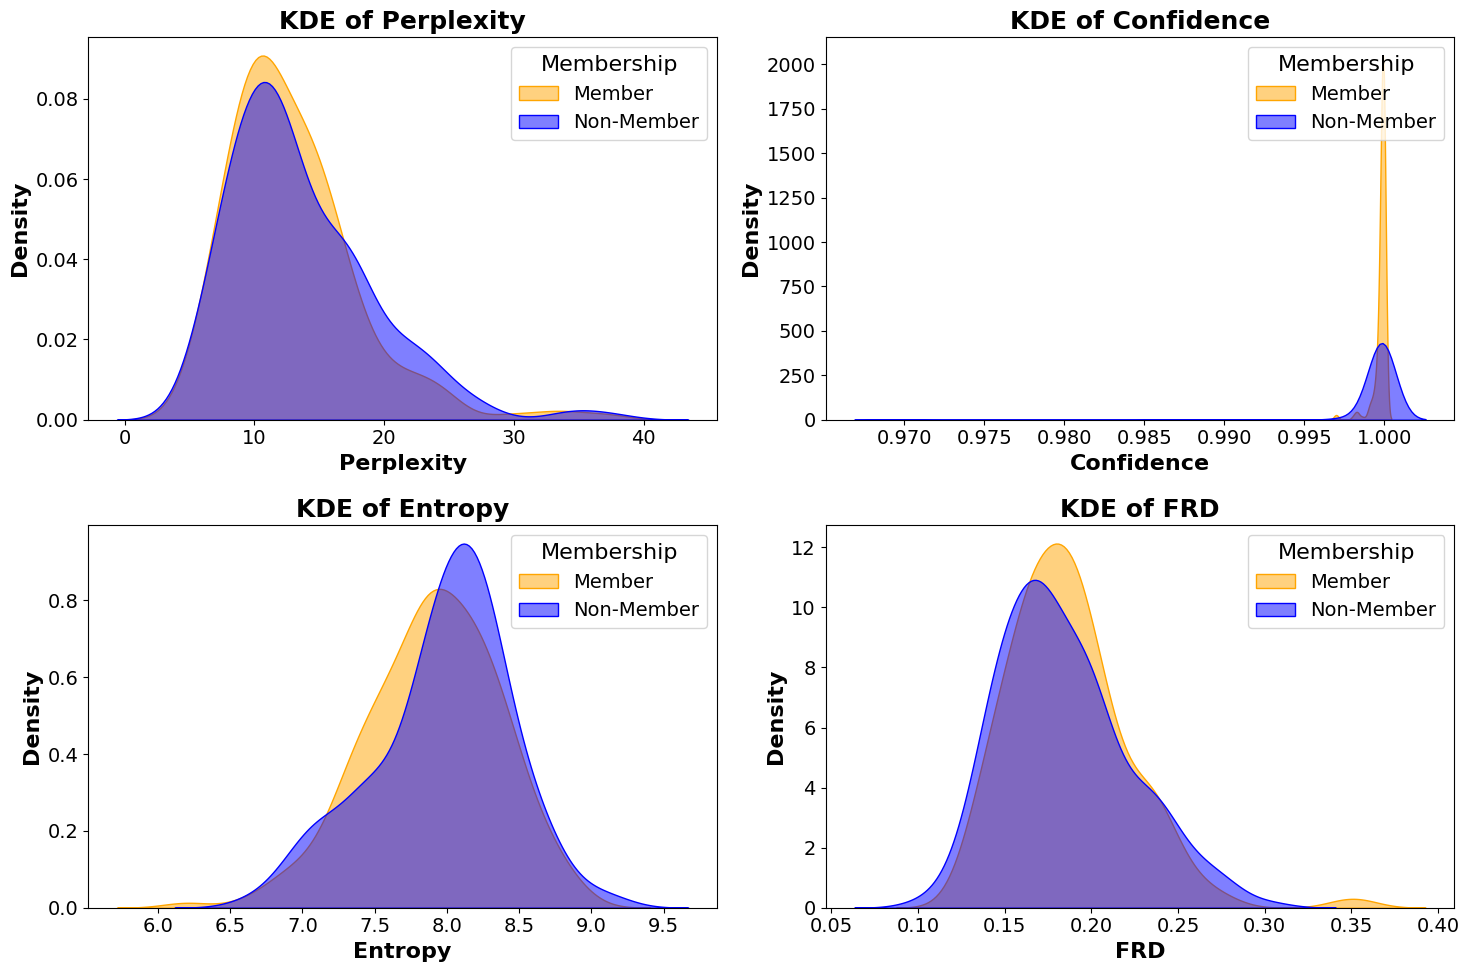

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract individual feature arrays
train_perplexities, train_confidences, train_entropies, train_frd = train_features
test_perplexities, test_confidences, test_entropies, test_frd = test_features

# Combine train and test features for each category
perplexities = np.concatenate([train_perplexities, test_perplexities])
confidences = np.concatenate([train_confidences, test_confidences])
entropies = np.concatenate([train_entropies, test_entropies])
frd_distances = np.concatenate([train_frd, test_frd])

# Combine member (1) and non-member (0) labels
labels = np.concatenate([[1] * len(train_perplexities), [0] * len(test_perplexities)])

df = pd.DataFrame({
    "Perplexity": perplexities,
    "Confidence": confidences,
    "Entropy": entropies,
    "FRD": frd_distances,
    "Membership": labels
})

# Convert Membership to categorical for seaborn
df["Membership"] = df["Membership"].map({1: "Member", 0: "Non-Member"})
# Set global font settings
plt.rcParams.update({
    "font.size": 16,      # Increase font size
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.title_fontsize": 16,
    "axes.labelsize": 16,
})
# Plot KDE for each feature
features = ["Perplexity", "Confidence", "Entropy", "FRD"]
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=df, x=feature, hue="Membership", fill=True, common_norm=False, alpha=0.5, palette={"Member": "blue", "Non-Member": "orange"} )
    plt.title(f"KDE of {feature}",fontweight="bold",fontsize=18)
    plt.xlabel(feature,fontweight="bold",fontsize=16)
    plt.ylabel("Density",fontweight="bold",fontsize=16)
    plt.legend(
        title="Membership", 
        loc="upper right", 
        labels=["Member", "Non-Member"], 
        frameon=True
    )

plt.tight_layout()

plt.savefig("lora_dp_med_txt_gen_kde_plots.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()
PROMPT_LENGTH=50
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    return inputs

def decode_tokens(tokens):
    return [tokenizer.decode([token]) for token in tokens]

def compute_shap_values(model, tokenizer, text, max_length=300):
    inputs = tokenize_text(text)
    input_ids = inputs["input_ids"].to(device)  # Extract the 'input_ids' tensor
    #print(f"INPUT IDS: {input_ids} and SHAPE: {input_ids.shape}")
    # Generate synthetic texts with prompts (subset of input_ids)
    prompts = input_ids[:, :PROMPT_LENGTH]  # Slice to use only the first 50 tokens as the prompt
    generated_ids = model.generate(input_ids=prompts,max_length=300+10,do_sample=True,top_k=90,temperature=0.8,top_p=0.95, num_beams=8, 
                                       no_repeat_ngram_size=4,early_stopping=True, repetition_penalty=1.5, length_penalty=1.0,
                                       pad_token_id=tokenizer.pad_token_id,eos_token_id=tokenizer.eos_token_id)
    #input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)      
    tokens = tokenizer.tokenize(text)
    input_texts_np = np.array(tokens).reshape(-1, 1)
    #print(f"INPUT IDS: {input_texts_np} and SHAPE: {input_texts_np.shape}")
    explainer = shap.KernelExplainer(
           lambda texts: model(**tokenizer(list(texts.flatten()), return_tensors="pt", 
                                                      padding=True, truncation=True).to(device)).logits[:, -1, :].cpu().detach().numpy(), input_texts_np  # Baseline as 2D NumPy array
    )
    #shap_values = explainer.shap_values(input_texts_np, nsamples=100)
    #token_importances = np.mean(np.abs(shap_values), axis=-1).flatten()
    #print(f"TOKEN IMP: {token_importances}")
    shap_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)   
    print(shap_texts[0])
    gen_inputs = tokenize_text(shap_texts[0])
    gen_input_ids = gen_inputs["input_ids"].to(device)  # Extract the 'input_ids' tensor    
    gen_tokens = tokenizer.tokenize(shap_texts[0])
    shap_texts_np = np.array(gen_tokens).reshape(-1, 1) 
    shap_values = explainer.shap_values(shap_texts_np, nsamples=100)    
    return shap_texts[0], shap_values
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration was 6.2 h on both study nights), and sleep stage distribution was similar on both nights. Obstructive apneas and hypopneas (OAH) rose from 114 +/- 43 during C to 170 +/- 49 during OPA (p less than 0.02). Central apneas and hypopneas (CAH) were unchanged between the two nights (8 +/- 4.9 versus 7 +/- 3). The duration of OAH was similar on both study nights (20 +/- 1.9 s during C versus 20 +/- 1.5 s during OPA). The frequency of movement arousals terminating OAH tended to be higher during OPA (7 +/- 2.9/h) than during C (3 +/- 0.7); P = NS. The frequency of oxyhemoglobin desaturations was also higher during OPA (5 +/- 2.1/h) than during C (3 +/- 1.4), p less than 0.07."
# Compute SHAP values for tokens
text, shap_values = compute_shap_values(model, tokenizer, text)
#print(f"Raw SHAP values:{shap_values} SHAPE:{shap_values.shape}")
# Extract token importance
#token_importances = np.mean(np.abs(shap_values), axis=-1).flatten()
token_importances = np.mean(shap_values, axis=-1).flatten()
# Decode tokens
tokens = decode_tokens(tokenizer(text, return_tensors="pt")["input_ids"][0].tolist())
print(len(tokens))
print(len(token_importances))
#for i, (token, importance) in enumerate(zip(tokens, token_importances)):
#    #if i < 10:  # Limit to the first 10 for debug purposes
#    print(f"I:  {i} Token: {token} | SHAP Value: {importance}")




The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
01/28/2025 18:35:22:WARNING:Using 379 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that this reflex may contribute to the development of obstructive sleep apnoea (OSA) following topical ophthalmic anesthesia. Twenty-four patients with snoring were randomly assigned to one of three groups: 1) oral ophthalmic lidocaine, 2) topical lidocaine alone, or 3) a combination of oral lidocaine and lidocaine plus lidocaine. OSA was assessed at baseline and at 6, 12, 24, 36, 48, 72, 96, and 120 hours postoperatively. Oral lidocaine was associated with a significant reduction in OSA (P < 0.001). However, there was no significant difference in OSA between the three groups (P > 0.05). There was a significant increase in OSA in the lidocaine group compared with the other two groups (P = 0.03). These data suggest that the upp

100%|██████████| 310/310 [00:18<00:00, 16.83it/s]


310
310


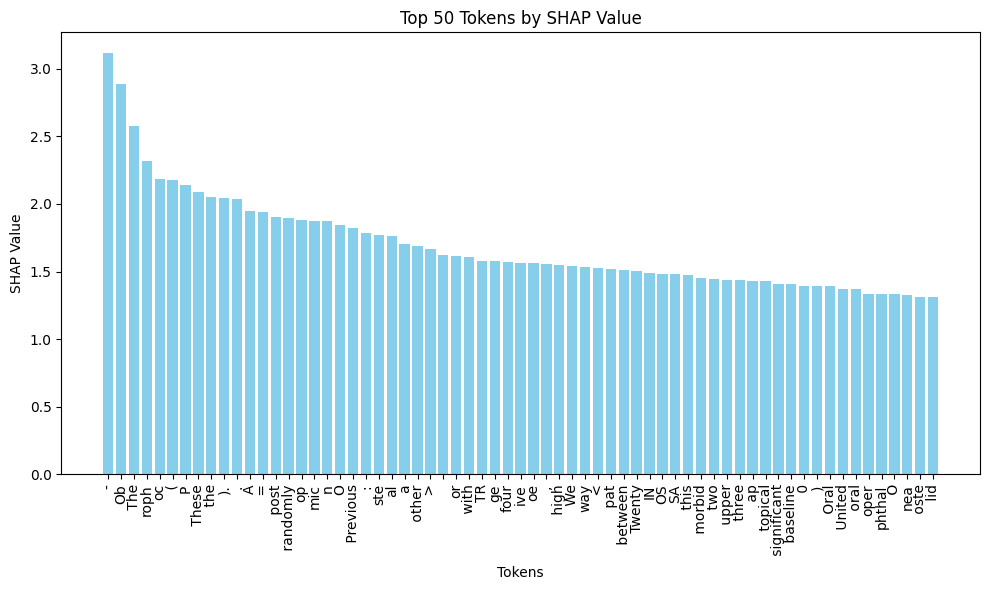

In [11]:
# Initialize empty lists for tokens and SHAP values
tokens_list = []
shap_values_list = []

# Iterate through the tokens and their corresponding SHAP values
for i, (token, importance) in enumerate(zip(tokens, token_importances)):
    # Add token and importance to the lists
    tokens_list.append(token)
    shap_values_list.append(importance)

# Create a list of tuples (token, shap_value) and sort by shap_value in descending order
sorted_tokens_shap = sorted(zip(tokens_list, shap_values_list), key=lambda x: abs(x[1]), reverse=True)

# Get the top 50 tokens and SHAP values
top_50_tokens, top_50_shap_values = zip(*sorted_tokens_shap[:150])

# Plotting the top 50 SHAP values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_50_tokens, top_50_shap_values, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('SHAP Value')
plt.xticks(rotation=90)
plt.title('Top 50 Tokens by SHAP Value')
plt.tight_layout()  # Adjust layout to avoid overlapping labels
plt.show()


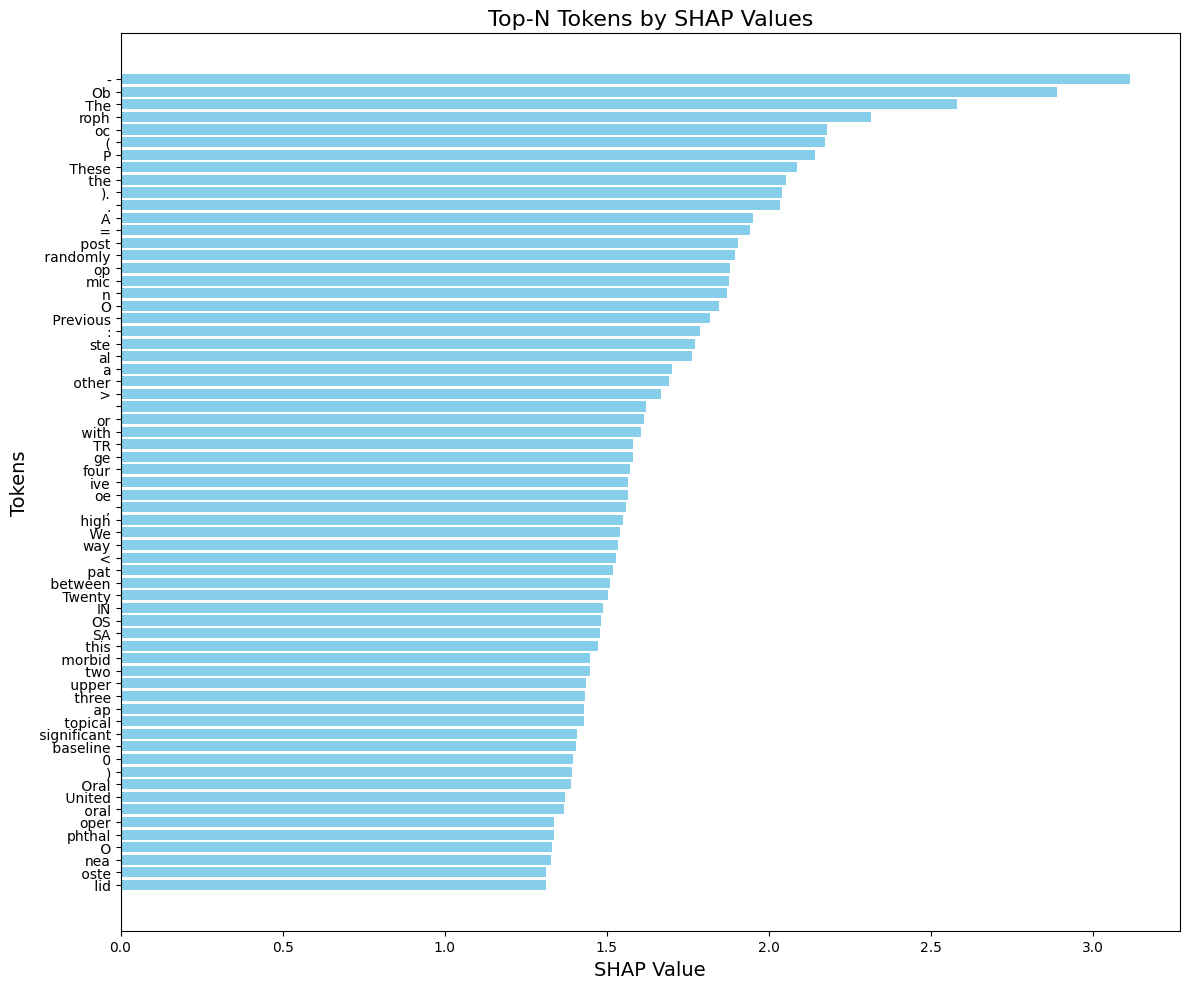

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the bar chart
plt.figure(figsize=(12, 10))
plt.barh(top_50_tokens, top_50_shap_values, color="skyblue")
plt.xlabel("SHAP Value", fontsize=14)
plt.ylabel("Tokens", fontsize=14)
plt.title("Top-N Tokens by SHAP Values", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to display highest SHAP value at the top
plt.tight_layout()
plt.show()


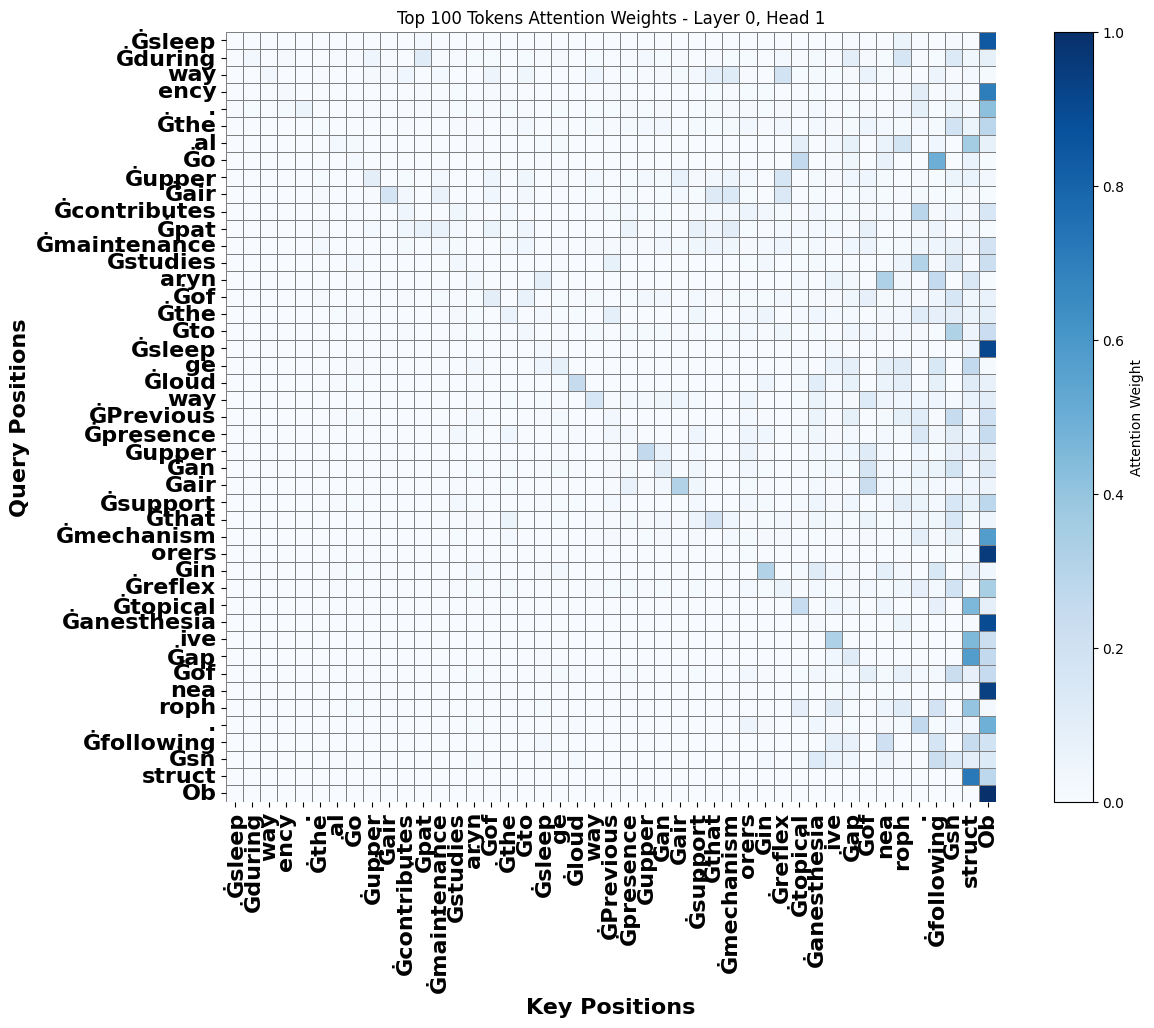

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
def visualize_attention(model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=150, filename="attention_heatmap.jpg"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions
    attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    avg_attention = attention_matrix.mean(axis=0)
    top_indices = np.argsort(avg_attention)[-top_n_tokens:]
    top_tokens = [tokens[i] for i in top_indices]
    top_attention_matrix = attention_matrix[np.ix_(top_indices, top_indices)]
    df = pd.DataFrame(top_attention_matrix, index=top_tokens, columns=top_tokens)
    df.to_csv("lora_dp_med_txt_gen_top_attention_matrix.csv")
    plt.figure(figsize=(15, 10))
    # Create the heatmap and store the result (QuadMesh object)
    heatmap = sns.heatmap(
        top_attention_matrix,
        cmap="Blues",
        linewidths=0.5,
        linecolor="gray",
        square=True,
        cbar=False,
        vmin=0, vmax=1,
        xticklabels=top_tokens, yticklabels=top_tokens
    )
    plt.xticks(rotation=90, fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.xlabel("Key Positions", fontsize=16, fontweight='bold')
    plt.ylabel("Query Positions", fontsize=16, fontweight='bold')
    plt.title(f"Top {top_n_tokens} Tokens Attention Weights - Layer {layer_idx+1}, Head {head_idx+1}")
    plt.colorbar(heatmap.collections[0], label="Attention Weight") # Pass the QuadMesh object to colorbar

    plt.savefig(filename)
    plt.show()
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep."

# Example usage
visualize_attention(generator_model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=100, filename="lora_dp_med_txt_gen_attn_map.jpg")


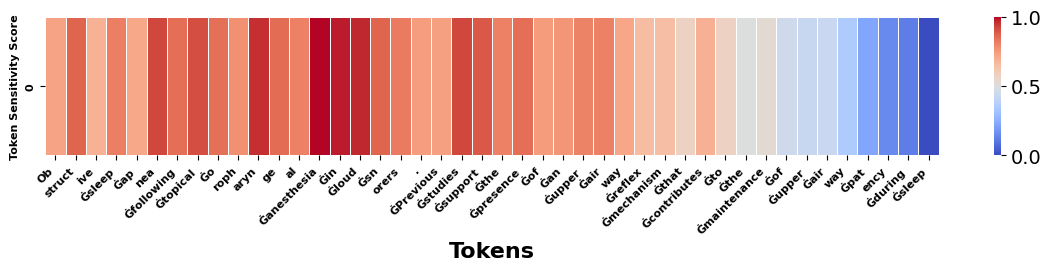

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def compute_token_sensitivity(text):
    """Compute token sensitivity by measuring logit differences when modifying tokens."""
    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True).to("cuda")
    input_ids = tokens["input_ids"]

    with torch.no_grad():
        base_logits = generator_model(**tokens).logits[:, :-1, :]  # Exclude final token prediction

    sensitivities = []

    for i in range(input_ids.shape[1] - 1):  # Exclude last token
        perturbed_ids = input_ids.clone()
        perturbed_ids[:, i] = tokenizer.eos_token_id  # Use end-of-text token instead of MASK

        with torch.no_grad():
            perturbed_logits = generator_model(input_ids=perturbed_ids).logits[:, :-1, :]

        # Compute sensitivity as logit difference norm
        diff = torch.norm(base_logits - perturbed_logits, dim=-1).mean().item()
        sensitivities.append(diff)

    # Normalize scores to [0,1]
    sensitivities = np.array(sensitivities)
    sensitivities = (sensitivities - sensitivities.min()) / (sensitivities.max() - sensitivities.min() + 1e-8)

    return tokenizer.convert_ids_to_tokens(input_ids[0][:-1].tolist()), sensitivities

def plot_token_sensitivity(text, threshold_high=0.7, threshold_low=0.3):
    """
    Plot heatmap for token sensitivity visualization, highlighting high and low sensitivity tokens.

    Args:
        text: The input text string.
        threshold_high: Threshold for considering a token as having high sensitivity (between 0 and 1).
        threshold_low: Threshold for considering a token as having low sensitivity (between 0 and 1).
    """
    tokens, scores = compute_token_sensitivity(text)

    # Identify high and low sensitivity tokens
    high_sensitive_tokens = [
        (token, score) for token, score in zip(tokens, scores) if score >= threshold_high
    ]
    low_sensitive_tokens = [
        (token, score) for token, score in zip(tokens, scores) if score <= threshold_low
    ]

    # Print high and low sensitive tokens
    #print("High Sensitivity Tokens (Sensitivity >= {:.2f}):".format(threshold_high))
    #for token, score in high_sensitive_tokens:
    #    print(f"  {token}: {score:.2f}")

    #print("\nLow Sensitivity Tokens (Sensitivity <= {:.2f}):".format(threshold_low))
    #for token, score in low_sensitive_tokens:
    #    print(f"  {token}: {score:.2f}")

   # Create a list of labels for the heatmap
    labels =[]
    # Create a new list of scores, where intermediate sensitivity tokens are masked
    masked_scores =[]
    for i, score in enumerate(scores):
        if 0.3 <= score <= 1.0 or 0.0 <= score <= 0.3:
            masked_scores.append(score)
            labels.append(tokens[i])  # Keep the label for high/low sensitivity
        else:
            masked_scores.append(np.nan)  # Use NaN to mask intermediate values
            labels.append("")  # Empty string for intermediate sensitivity


    plt.figure(figsize=(12, 3))
    sns.heatmap([masked_scores], cmap="coolwarm", linewidths=0.5, cbar=True,
                mask=np.isnan([masked_scores]))  # Use mask to hide NaN cells
    plt.xticks(ticks=np.arange(len(tokens)) + 0.5, labels=labels, rotation=45, ha="right", fontweight="bold", fontsize=8)
    plt.xlabel("Tokens",fontweight="bold",fontsize=16)
    plt.yticks(fontweight="bold",fontsize=8)
    plt.ylabel("Token Sensitivity Score",fontweight="bold",fontsize=8)
    plt.title("")
    plt.tight_layout()
    plt.savefig('lora_dp_med_txt_gen_tkn_smap.jpg')
    plt.show()
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep."
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator_model.to(device)
generator_model.eval()
plot_token_sensitivity(text)